<a href="https://colab.research.google.com/github/Arpitkamal/Deep-Learning-104-Feedforward-Neural-Networks/blob/master/FeedForwardNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Outline


1.   Generate data that is not linearly separable
2.   Train with SN and see performance
3.   Write from scratch our first feed forward network 
4.   Train the FF network on the data and compare with SN
5.   Write a generic class for a FF network
6.   Train generic class on binary classification
7.   Generate data for multi-class classification
8.   Train a FF network for step 7
9.   Use softmax as the output layer and cross-entropy as loss function
10.  Train with step 8 for mutli-class classification
11.  Exercises on other datasets



# Setup

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [0]:
class SigmoidNeuron:

  def __init__(self):
    self.w = None
    self.b = None

  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b

  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))    

  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x

  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)

  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x)) 
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")

  def grad_b_ce(self, x, y):
     y_pred = self.sigmoid(self.perceptron(x))
     if y == 0:
       return y_pred
     elif y == 1:
       return -1 * (1 - y_pred)
     else:
       raise ValueError("y should be 0 or 1")        

  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):

     #initialise w, b
     if initialise:
       self.w = np.random.randn(1,X.shape[1])
       self.b = 0

     if display_loss:
       loss = {}

     for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
       dw = 0
       db = 0
       for x, y in zip(X, Y):
         if loss_fn == "mse":
           dw += self.grad_w_mse(x, y)
           db += self.grad_b_mse(x, y)
         elif loss_fn =="ce":
           dw += self.grad_w_ce(x, y)
           db += self.grad_b_ce(x, y)

       m = X.shape[1]
       self.w -= learning_rate * dw/m 
       self.b -= learning_rate * db/m

       if display_loss:
         Y_pred = self.sigmoid(self.perceptron(X))
         if loss_fn == "mse":
           loss[i] = mean_squared_error(Y, Y_pred)    
         elif loss_fn == "ce":
           loss[i] = log_loss(Y, Y_pred)

     if display_loss:
       plt.plot(list(loss.values()))
       plt.xlabel('Epochs')
       if loss_fn == "mse":
         plt.ylabel('Mean Squared Error')
       elif loss_fn == "ce":
         plt.ylabel('Log Loss')
       plt.show()

  def predict(self, X):
     Y_pred = []
     for x in X:
       y_pred = self.sigmoid(self.perceptron(x))
       Y_pred.append(y_pred)
     return np.array(Y_pred)

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# Generate Data

**Generting data with 4 classes**

In [4]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


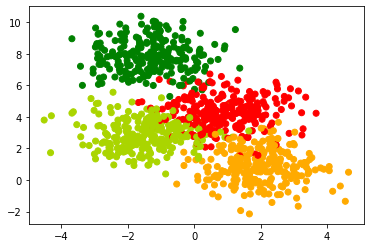

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

**making 2 classes now for binary classification**

In [0]:
labels_orig = labels
labels = np.mod(labels, 2)

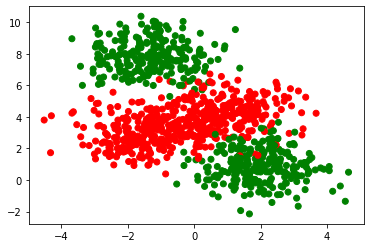

In [7]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape)

(750, 2) (250, 2)


# SN classification

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


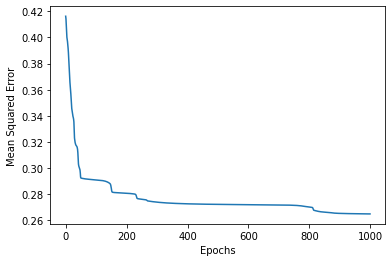

In [9]:
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, epochs=1000, learning_rate=0.5, display_loss=True)

In [10]:
Y_pred_train = sn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = sn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.73
Validation accuracy 0.72


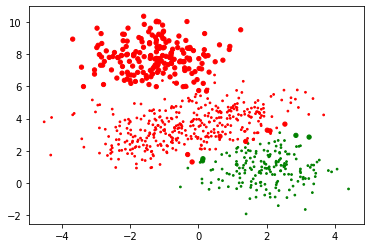

In [11]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()

**Bigger points are being wrongly predicted**

# Our First FF Network

![Neral Network with 1 hidden layer](https://miro.medium.com/max/700/1*d4LePGHpwTUV6Ycz4l_xww.png)

# Feed Forward Network - Generic Class

In [0]:
class FFSNNetwork:

  def __init__(self, n_inputs, hidden_size=[2]):
    self.nx = n_inputs
    self.ny = 1
    self.nh = len(hidden_size)
    self.sizes = [self.nx] + hidden_size + [self.ny]

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))

  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    return self.H[self.nh+1]

  def grad_sigmoid(self, x):
    return x*(1-x)

  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k]) 
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))

  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):

     #initialise w, b
     if initialise:
       for i in range(self.nh+1):
         self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
         self.B[i+1] = np.zeros((1, self.sizes[i+1]))

     if display_loss:
       loss = {}

     for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
       dW = {}
       dB = {}
       for i in range(self.nh+1):
         dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
         dB[i+1] = np.zeros((1, self.sizes[i+1]))
       for x, y in zip(X, Y):
         self.grad(x, y)
         for i in range(self.nh+1):
           dW[i+1] += self.dW[i+1]
           dB[i+1] += self.dB[i+1] 

       m = X.shape[1]
       for i in range(self.nh+1):
         self.W[i+1] -= learning_rate * dW[i+1] / m 
         self.B[i+1] -= learning_rate * dB[i+1] / m 

       if display_loss:
         Y_pred = self.predict(X)
         loss[e] = mean_squared_error(Y_pred, Y)
           

     if display_loss:
       plt.plot(list(loss.values()))
       plt.xlabel('Epochs')
       plt.ylabel('Mean Squared Error')
       plt.show()

  def predict(self, X):
     Y_pred = []
     for x in X:
       y_pred = self.forward_pass(x)
       Y_pred.append(y_pred) 
     return np.array(Y_pred).squeeze    


In [67]:
 ffsnn = FFSNNetwork(2, [3, 3])
 ffsnn.fit(X_train, Y_train, epochs=2000, learning_rate=0.001, display_loss=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


TypeError: ignored

In [15]:
  Y_pred_train = ffsnn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = ffsnn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.98
Validation accuracy 0.94


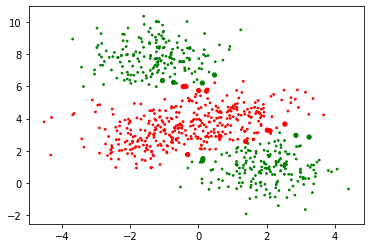

In [16]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_binarised_train, cmap=my_cmap, s=15*(np.abs(Y_pred_binarised_train-Y_train)+.2))
plt.show()

# Multyclass classification

In [0]:
class FFSN_MultiClass:

  def __init__(self, n_inputs, n_outputs,  hidden_size=[3]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_size)
    self.sizes = [self.nx] + hidden_size + [self.ny]

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1]) 
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))

  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))

  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)  
 
  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh+1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[i+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])  
    return self.H[self.nh+1]

  def grad_sigmoid(self, x):
    return x*(1-x)

  def cross_entropy(self, label, pred):
    y1= np.multiply(pred, label)
    y1= y1[y1!=0]
    y1=-np.log(y1)
    y1=np.mean(y1)
    return y1     

  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k]) 
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1]))

  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True  , display_loss=False):

     #initialise w, b
     if initialise:
       for i in range(self.nh+1):
         self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
         self.B[i+1] = np.zeros((1, self.sizes[i+1]))

     if display_loss:
       loss = {}

     for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
       dW = {}
       dB = {}
       for i in range(self.nh+1):
         dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
         dB[i+1] = np.zeros((1, self.sizes[i+1]))
       for x, y in zip(X, Y):
         self.grad(x, y)
         for i in range(self.nh+1):
           dW[i+1] += self.dW[i+1]
           dB[i+1] += self.dB[i+1] 

       m = X.shape[1]
       for i in range(self.nh+1):
         self.W[i+1] -= learning_rate * (dW[i+1] / m) 
         self.B[i+1] -= learning_rate * (dB[i+1] / m) 

       if display_loss:
         Y_pred = self.predict(X)
         loss[e] = self.cross_entropy(Y, Y_pred)

     if display_loss:
       plt.plot(list(loss.values()))
       plt.xlabel('Epochs')
       plt.ylabel('Cross entropy')
       plt.show()

  def predict(self, X):
     Y_pred = []
     for x in X:
       y_pred = self.forward_pass(x)
       Y_pred.append(y_pred)
     return np.array(Y_pred).squeeze()    


In [42]:
  X_train, X_val, Y_train, Y_val = train_test_split(data, labels_orig, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, labels_orig.shape)

(750, 2) (250, 2) (1000,)


In [43]:
enc = OneHotEncoder()
# 0 -> (1,0,0,0), 1 -> (0,1,0,0), 2 -> (0,0,1,0), 3 -> (0,0,0,1)
y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
y_OH_val = enc.fit_transform(np.expand_dims(Y_val,1)).toarray()
print(y_OH_train.shape, y_OH_val.shape)

(750, 4) (250, 4)


In [0]:
ffsn_multi = FFSN_MultiClass(2,4,[2,3])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


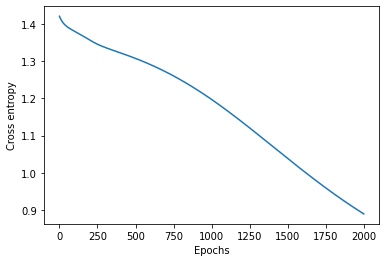

In [54]:
ffsn_multi.fit(X_train, y_OH_train,epochs=2000, learning_rate=0.0001, display_loss=True)

In [49]:
Y_pred_train = ffsn_multi.predict(X_train)
Y_pred_train = np.argmax(Y_pred_train, 1)

Y_pred_val = ffsn_multi.predict(X_val)
Y_pred_val = np.argmax(Y_pred_val,1)

accuracy_train = accuracy_score(Y_pred_train, Y_train)
accuracy_train = accuracy_score(Y_pred_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.92
Validation accuracy 0.94


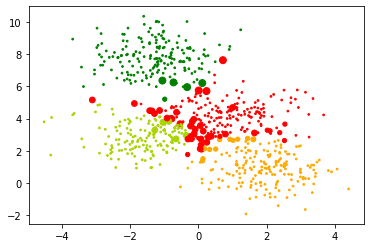

In [53]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(Y_pred_train-Y_train)+.2))
plt.show()